## Visualising and modelling luxury watches in Python ⌚💸

In [14]:
import numpy as np
import pandas as pd
from plotnine import *

pd.set_option('display.max_columns', 500)

In [15]:
data = pd.read_csv("watches_clean.csv")

In [40]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45530 entries, 0 to 45529
Data columns (total 29 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   header              45530 non-null  object 
 1   price               43635 non-null  float64
 2   response_time       36992 non-null  object 
 3   inseratscode        45530 non-null  object 
 4   marke               45530 non-null  object 
 5   modell              41701 non-null  object 
 6   referenznummer      43134 non-null  object 
 7   code_des_handlers   28073 non-null  object 
 8   aufzug              43405 non-null  object 
 9   material_gehause    42509 non-null  object 
 10  material_armband    38304 non-null  object 
 11  herstellungsjahr    29309 non-null  float64
 12  zustand             43114 non-null  object 
 13  lieferumfang        45530 non-null  object 
 14  geschlecht          39565 non-null  object 
 15  standort            45530 non-null  object 
 16  verf

In [16]:
data.head()

,header,price,response_time,inseratscode,marke,modell,referenznummer,code_des_handlers,aufzug,material_gehause,material_armband,herstellungsjahr,zustand,lieferumfang,geschlecht,standort,verfugbarkeit,kaliber_werk,durchmesser,material_lunette,glas,zifferblatt,zahlen_zifferblatt,farbe_armband,schliesse,material_schliesse,gangreserve_h,anzahl_steine,wasserdichtigkeit
0,Audemars Piguet Royal Oak Jumbo Jubilee 20th A...,128000.0,Durchschnittliche Antwortzeit 1 Stunde,G47F21,Audemars Piguet,Royal Oak Jumbo,14802ST,*AP146,Automatik,Stahl,Stahl,1995.0,Sehr gut,"Mit Original-Papieren, ohne Original-Box",Herrenuhr/Unisex,"Schweiz, Geneve",Artikel auf Lager,2121,39.0,Stahl,Saphirglas,Grau,Keine Ziffern,Stahl,Faltschließe,Stahl,NaN,NaN,NaN
1,Rolex Daytona116515LN Black Diamond Neu 2022 F...,44750.0,Durchschnittliche Antwortzeit 7 Stunden,G3G3U9,Rolex,Daytona,116515ln,NaN,Automatik,Roségold,Kautschuk,2022.0,Neu,"Mit Original-Box, mit Original-Papieren",Herrenuhr/Unisex,"Österreich, Wien",Artikel auf Lager,4130,40.0,Keramik,Saphirglas,Schwarz,Keine Ziffern,Schwarz,Faltschließe,Roségold,72.0,44.0,10 ATM
2,Rolex Air King 1 2023 Box Papers NEW Partially...,10350.0,Durchschnittliche Antwortzeit 2 Stunden,G7W0E0,Rolex,Air King,126900,NaN,Automatik,Stahl,Stahl,2023.0,Neu,"Mit Original-Box, mit Original-Papieren",Herrenuhr/Unisex,"Österreich, Wien",Artikel auf Lager,3230,40.0,Stahl,Saphirglas,Schwarz,Arabisch,Stahl,Faltschließe,Stahl,70.0,31.0,10 ATM
3,Tudor StyleBlue Datejust 12510 38mm Full Set,2200.0,Durchschnittliche Antwortzeit 4 Stunden,G3QGJ5,Tudor,Style,12510,NaN,Automatik,Stahl,Stahl,2022.0,Sehr gut,"Mit Original-Box, mit Original-Papieren",Herrenuhr/Unisex,"Österreich, Schwaz",Artikel auf Lager,NaN,38.0,NaN,NaN,Blau,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Rolex Oyster Perpetual 39Blue Dial like new wa...,6999.0,Durchschnittliche Antwortzeit 4 Stunden,G5VUX7,Rolex,Oyster Perpetual 39,114300,NaN,Automatik,Stahl,Stahl,NaN,Sehr gut,"Ohne Original-Box, ohne Original-Papiere",Herrenuhr/Unisex,"Österreich, Wien",Artikel auf Lager,3132,39.0,Stahl,Saphirglas,Blau,Keine Ziffern,Stahl,Faltschließe,Stahl,48.0,31.0,10 ATM


## Training a model to predict watch prices

In [17]:
from lightgbm import LGBMRegressor
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, KNNImputer
from sklearn.pipeline import FeatureUnion, make_pipeline, Pipeline
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.metrics import r2_score, mean_absolute_error, mean_absolute_percentage_error
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn import config_context

config_context(transform_output="pandas")

In [18]:
full_data = (
    data
    .drop(columns=["response_time", "inseratscode", "referenznummer", "code_des_handlers"], axis=1)
    .dropna(subset="price")
    .copy()
)

In [19]:
for col in full_data.select_dtypes(include="object").columns:
    full_data[col] = full_data[col].astype("category")

In [20]:
# Split into X and y
X, y = full_data.drop("price", axis=1), full_data["price"]

# Make splits
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [34]:
# Column selectors for preparation
num_cols = make_column_selector(dtype_include="number")
cat_cols = make_column_selector(dtype_exclude="number")

# Making transformers
numeric_transformer = Pipeline(steps=[
    ("Imputer", SimpleImputer(strategy="mean"))
])

categorical_transformer = Pipeline(steps=[
    ("Imputer", SimpleImputer(strategy="constant", fill_value="unknown")),
    ("Encoder", OneHotEncoder(min_frequency=0.05, sparse_output=False,
                              handle_unknown='ignore'))
])

# Making column transformer
preprocessor = ColumnTransformer(
    transformers=[("numeric", numeric_transformer, num_cols),
                  ("categorical", categorical_transformer, cat_cols)],
    remainder="passthrough"
)

# Making model pipeline for lightgbm
lgbm_pipeline = Pipeline(steps=[
    ("preprocessing", preprocessor),
    ("LGBMmodel", LGBMRegressor())
])

In [22]:
# see transformed dataset
pd.DataFrame(lgbm_pipeline[:-1].fit_transform(X_train, y_train),
             columns=lgbm_pipeline[:-1].get_feature_names_out())


C:\Users\mathi\AppData\Roaming\Python\Python310\site-packages\sklearn\preprocessing\_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.


,numeric__herstellungsjahr,numeric__durchmesser,numeric__gangreserve_h,numeric__anzahl_steine,categorical__header_infrequent_sklearn,categorical__marke_Breitling,categorical__marke_Omega,categorical__marke_Rolex,categorical__marke_infrequent_sklearn,categorical__modell_Datejust 36,categorical__modell_unknown,categorical__modell_infrequent_sklearn,categorical__aufzug_Automatik,categorical__aufzug_Handaufzug,categorical__aufzug_Quarz,categorical__aufzug_infrequent_sklearn,categorical__material_gehause_Gelbgold,categorical__material_gehause_Gold/Stahl,categorical__material_gehause_Stahl,categorical__material_gehause_unknown,categorical__material_gehause_infrequent_sklearn,categorical__material_armband_Gold/Stahl,categorical__material_armband_Kautschuk,categorical__material_armband_Leder,categorical__material_armband_Stahl,categorical__material_armband_unknown,categorical__material_armband_infrequent_sklearn,categorical__zustand_Gut,categorical__zustand_Neu,categorical__zustand_Sehr gut,categorical__zustand_Ungetragen,categorical__zustand_unknown,categorical__zustand_infrequent_sklearn,"categorical__lieferumfang_Mit Original-Box, mit Original-Papieren","categorical__lieferumfang_Mit Original-Box, ohne Original-Papiere","categorical__lieferumfang_Mit Original-Papieren, ohne Original-Box","categorical__lieferumfang_Ohne Original-Box, ohne Original-Papiere",categorical__geschlecht_Damenuhr,categorical__geschlecht_Herrenuhr/Unisex,categorical__geschlecht_unknown,"categorical__standort_Japan, Tokyo",categorical__standort_infrequent_sklearn,categorical__verfugbarkeit_Artikel auf Lager,categorical__verfugbarkeit_Artikel muss bestellt werden,categorical__verfugbarkeit_infrequent_sklearn,categorical__kaliber_werk_unknown,categorical__kaliber_werk_infrequent_sklearn,categorical__material_lunette_Gelbgold,categorical__material_lunette_Keramik,categorical__material_lunette_Stahl,categorical__material_lunette_unknown,categorical__material_lunette_infrequent_sklearn,categorical__glas_Plexiglas,categorical__glas_Saphirglas,categorical__glas_unknown,categorical__glas_infrequent_sklearn,categorical__zifferblatt_Blau,categorical__zifferblatt_Schwarz,categorical__zifferblatt_Silber,categorical__zifferblatt_Weiß,categorical__zifferblatt_unknown,categorical__zifferblatt_infrequent_sklearn,categorical__zahlen_zifferblatt_Arabisch,categorical__zahlen_zifferblatt_Keine Ziffern,categorical__zahlen_zifferblatt_unknown,categorical__zahlen_zifferblatt_infrequent_sklearn,categorical__farbe_armband_Gold/Stahl,categorical__farbe_armband_Schwarz,categorical__farbe_armband_Stahl,categorical__farbe_armband_unknown,categorical__farbe_armband_infrequent_sklearn,categorical__schliesse_Dornschließe,categorical__schliesse_Faltschließe,categorical__schliesse_unknown,categorical__schliesse_infrequent_sklearn,categorical__material_schliesse_Stahl,categorical__material_schliesse_unknown,categorical__material_schliesse_infrequent_sklearn,categorical__wasserdichtigkeit_10 ATM,categorical__wasserdichtigkeit_3 ATM,categorical__wasserdichtigkeit_30 ATM,categorical__wasserdichtigkeit_5 ATM,categorical__wasserdichtigkeit_unknown,categorical__wasserdichtigkeit_infrequent_sklearn
0,2023.000000,33.000000,60.204818,30.356252,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,2023.000000,30.100000,60.204818,8.000000,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,2019.000000,70.365767,60.000000,54.000000,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.

In [35]:
model_trained = lgbm_pipeline.fit(X_train, y_train)

In [36]:
model_trained.predict(X_train)

array([  483.0932951 , -1255.26335174, 55169.87073913, ...,
       38843.68206743,  4466.99968135, 10792.68453921])

In [37]:
# Print the metrics for LGBM
print("LGBM Final Fit Metrics:")
print("--------------------------------")
print(f"R-Squared: {r2_score(y_pred=model_trained.predict(X_test), y_true=y_test)}")
print(f"MAE: {mean_absolute_error(y_pred=model_trained.predict(X_test), y_true=y_test)}")
print(f"MAPE: {mean_absolute_percentage_error(y_pred=model_trained.predict(X_test), y_true=y_test)}")

LGBM Final Fit Metrics:
--------------------------------
R-Squared: 0.20044268019690814
MAE: 7404.0769347701935
MAPE: 1.3722414675503871


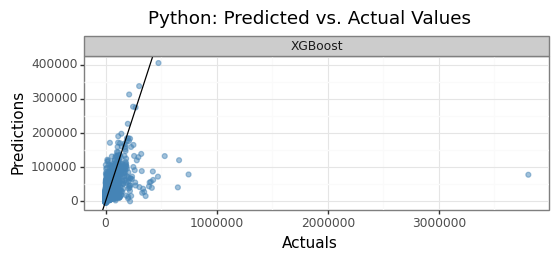

<ggplot: (137861212674)>

In [39]:
p = (
    ggplot(data=pd.DataFrame({"predictions": model_trained.predict(X_test),
                              "truth": y_test,
                              "model": "XGBoost"}), mapping=aes(x="truth", y="predictions")) +
    geom_point(colour="#4584b6", alpha=0.5) +
    geom_abline() +
    labs(title="Python: Predicted vs. Actual Values",
         y="Predictions", x="Actuals") +
    facet_wrap("~ model") +
    theme_bw() +
    theme(figure_size=[6, 2])
)

p